In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [3]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

The dataloader is compoosed of 6 batches, each of them of size 32 making a total of: 192, which is enough for storing the 179 images that we have in the positive dataset

In [4]:
print(len(dataloader))

6


In [5]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.) tensor(1.)


The problem with the above is that we expected the min value to be 0 according to a previous example.

    SOLVED: For the moment, we changed the order in which the operations of the transforms were applied. This resulted in what we initially expected: The min tensor value to be 0 and the max tensor value equals 1.


The following, is a way of formatting the image to be able to show them:

Converting the images to numpy to be able to show them

In [6]:
imgs = images.detach().numpy()
# imgs = images.numpy()     #We could also use this command to convert it to numpy array. Not sure about the differences
print(type(imgs))

<class 'numpy.ndarray'>


In [7]:
single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))

It is beleived that the above portion of code is not necessary, since "single_img" already has shape of 3 channels. It will only be necessary the permutation for displaying it correctly with matplotlib.

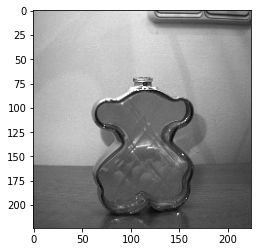

In [8]:
plt.imshow(new_img_to_show)

Aux function for converting an image saved in form of a tensor to the appropriate format for displaying it with plt.show()

In [9]:
def convert_for_display(img_in_tensor_type):
    img = img_in_tensor_type.detach().numpy()
    img_to_show = img * 255
    img_to_show = img_to_show.astype("uint8")
    one_channel_img = img_to_show[0]
    new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
    return new_img_to_show

In [10]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        # 32, 3, 224, 224
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> N, 110, 44, 44
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # -> N, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # -> N, 450, 1, 1
        )
        
        # N , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # -> 32, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # N, 3, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [13]:
# # Point to training loop video
# num_epochs = 10
# outputs = []
# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
        
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs.append((epoch, img, recon))

Saving and loading a model

In [14]:
filepath = "../../../BottlesAnomalies_TFM/models/pytorchModels/PytorchModel2"


In [15]:
# torch.save(model.state_dict(), filepath)

In [16]:
# For loading the model 
model.load_state_dict(torch.load(filepath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [17]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Original Images


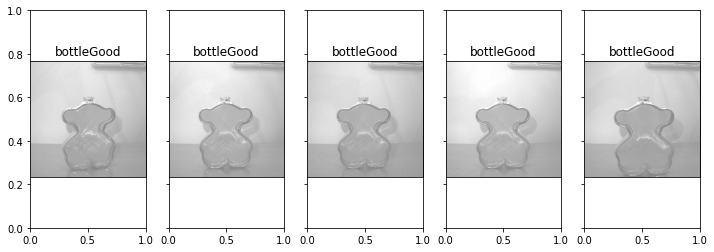

Reconstructed Images


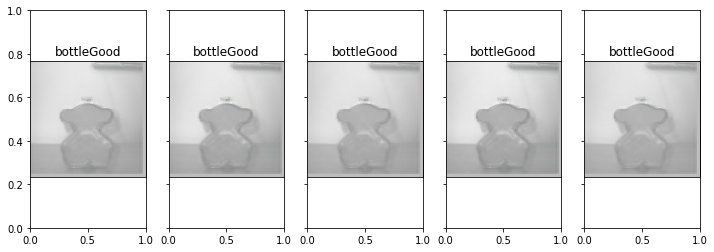

In [18]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)

#Sample outputs
output = model(images)

images = images.numpy()

output = output.view(32, 3, 224, 224)
output = output.detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing step by step tests. Considering only the first image of the dataset and obtaining its reconstruction.

In [19]:
print("The input data considering only one sample. Not a batch of samples")
X = dataset[0]
image_in_tensor = X[0]
print("The images are stored in a variable of type: ", type(image_in_tensor))
print("The min and max tensor values of the input is: ", torch.min(image_in_tensor), torch.max(image_in_tensor))
print("\n")
print("The reconstructed data onsidering only one sample. Not a batch of samples")
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)
print("The recontructed images are stored in a variable of type: ", type(Y))
print("The min and max tensor values of the reconstruction is: ", torch.min(Y), torch.max(Y))

The input data considering only one sample. Not a batch of samples
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.0199) tensor(1.)


The reconstructed data onsidering only one sample. Not a batch of samples
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0536) tensor(0.9660)


Making sure that "image_in_tensor" is actually the image of the dataset.

In [20]:
print("The shape of the image is: ", image_in_tensor.shape)
print("The type of the image is: ", type(image_in_tensor))

The shape of the image is:  torch.Size([3, 224, 224])
The type of the image is:  <class 'torch.Tensor'>


Displaying its content:

<class 'numpy.ndarray'>


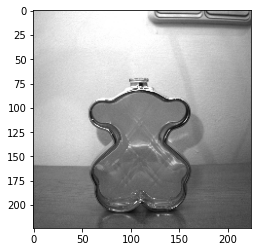

In [21]:
img = image_in_tensor.detach().numpy()
print(type(img))

img_to_show = img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.imshow(new_img_to_show)

Showing the shape of the reconstructed image:

In [22]:
print("The shape of the image is: ", Y.shape)
print("The type of the image is: ", type(Y))

The shape of the image is:  torch.Size([3, 224, 224])
The type of the image is:  <class 'torch.Tensor'>


Displaying the reconstructed image:

<class 'numpy.ndarray'>


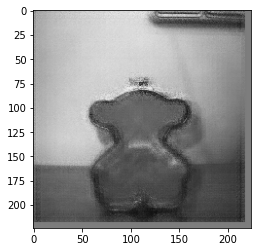

In [23]:
img = Y.detach().numpy()
print(type(img))

img_to_show = img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.imshow(new_img_to_show)

From above, we can be sure that the reconstructed and input original images are handled as expected. However, one detail to notice in the reconstructed image, is the fact that it seems to be filling some pixels with some sort of padding, see the bottom and right part of the reconstructed image. 

Computing the reconstruction error of the first image in the dataset

In [24]:
err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y))
print(err)
print(type(err))

err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
print(err)
print(type(err))

tensor(1870.1311)
<class 'torch.Tensor'>
1870.131103515625
<class 'float'>


Above error sum is the result of the three channels of the image. Let's see the error computation of each of the channels

In [25]:
err = torch.sum((image_in_tensor[0]-Y[0])*(image_in_tensor[0]-Y[0]))
print(err)
err2 = torch.sum((image_in_tensor[1]-Y[1])*(image_in_tensor[1]-Y[1]))
print(err2)
err3 = torch.sum((image_in_tensor[2]-Y[2])*(image_in_tensor[2]-Y[2]))
print(err3)

tensor(634.1509)
tensor(612.4442)
tensor(623.5360)


In [26]:
print(err+err2+err3)

tensor(1870.1311)


For the moment, the reconstruction error is not being divided by the number of pixels of the image, as it was done in the other reference program for computing this value. We will work in this way for the moment.

Above it was seen that the error values were different for each of the channels of the image. Let's analyze why

In [27]:
print(image_in_tensor.shape)

torch.Size([3, 224, 224])


In [28]:
first_channel = image_in_tensor[0]
scond_channel = image_in_tensor[1]
third_channel = image_in_tensor[2]

comparation_res = torch.eq(first_channel, scond_channel)
comparation_res= comparation_res.detach().numpy()
x = np.where(comparation_res == False)
print(x)
comparation_res2 = torch.eq(first_channel, third_channel)
comparation_res2= comparation_res2.detach().numpy()
x2 = np.where(comparation_res2 == False)
print(x2)


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Above we see that the three channels of the input image are exactly the same.

In [29]:
first_channel = Y[0]
scond_channel = Y[1]
third_channel = Y[2]

comparation_res = torch.eq(first_channel, scond_channel)
comparation_res= comparation_res.detach().numpy()
x = np.where(comparation_res == False)
print(x)
comparation_res2 = torch.eq(first_channel, third_channel)
comparation_res2= comparation_res2.detach().numpy()
x2 = np.where(comparation_res2 == False)
print(x2)


(array([  0,   0,   0, ..., 223, 223, 223], dtype=int64), array([  0,   1,   2, ..., 221, 222, 223], dtype=int64))
(array([  0,   0,   0, ..., 223, 223, 223], dtype=int64), array([  0,   1,   2, ..., 221, 222, 223], dtype=int64))


Above, it is seen that the channels of the reconstructed image are not the same among them. Hence, the reconstruction error is different for each of the input image channel. 

Performing the computation of the reconstruction error of all the images in the dataset

In [30]:
result_lst = []
# n_features = len(data_ds[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 1870.131103515625), (1, 992.2857666015625), (2, 1207.613037109375), (3, 583.0374755859375), (4, 543.7575073242188), (5, 583.98291015625), (6, 660.8671875), (7, 681.27001953125), (8, 617.3809814453125), (9, 611.3062744140625), (10, 584.5933227539062), (11, 552.8016357421875), (12, 993.7083129882812), (13, 934.829833984375), (14, 715.4749755859375), (15, 814.0592041015625), (16, 567.78759765625), (17, 906.7799072265625), (18, 741.2510986328125), (19, 1295.1072998046875), (20, 1539.088623046875), (21, 1507.3682861328125), (22, 1086.21484375), (23, 840.5142822265625), (24, 560.85498046875), (25, 650.840576171875), (26, 1026.4708251953125), (27, 1013.017822265625), (28, 1251.8984375), (29, 1178.7789306640625), (30, 628.6134643554688), (31, 623.8097534179688), (32, 1007.36376953125), (33, 1034.8321533203125), (34, 946.0338134765625), (35, 802.9981689453125), (36, 950.668212890625), (37, 1185.53564453125), (38, 1330.7833251953125), (39, 1489.232177734375), (40, 667.955810546875), (41, 78

The above function takes a relatevily considerable time to execute. See in the future to improve this

In [31]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 1870.131103515625), (120, 1615.70751953125), (146, 1551.402099609375), (155, 1546.7841796875), (20, 1539.088623046875), (176, 1531.8912353515625), (168, 1530.4027099609375), (21, 1507.3682861328125), (39, 1489.232177734375), (177, 1488.2723388671875), (175, 1462.99169921875), (137, 1408.4669189453125), (165, 1405.967041015625), (178, 1404.1558837890625), (163, 1344.701171875), (38, 1330.7833251953125), (164, 1301.61572265625), (167, 1296.4444580078125), (19, 1295.1072998046875), (169, 1294.58935546875), (161, 1294.2825927734375), (145, 1256.85546875), (162, 1256.52099609375), (28, 1251.8984375), (144, 1250.8291015625), (142, 1247.7958984375), (143, 1244.1539306640625), (141, 1235.64306640625), (60, 1226.6270751953125), (80, 1226.6270751953125), (166, 1224.8387451171875), (147, 1222.36376953125), (140, 1209.918212890625), (2, 1207.613037109375), (116, 1207.40087890625), (158, 1207.157470703125), (160, 1203.2471923828125), (170, 1197.226318359375), (139, 1192.204345703125), (159, 11

The image that resulted in the highest reconstruction error is:

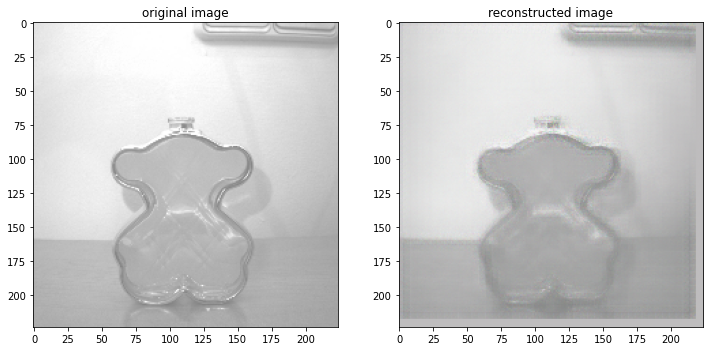

In [32]:
(idx,err) = result_lst[0]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

Y_img = Y.detach().numpy()
X_img = image_in_tensor.detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("original image")
imshow(X_img)
plt.subplot(122)
plt.title("reconstructed image")
imshow(Y_img)


Using another function for displaying the images, for better appreciation of the image

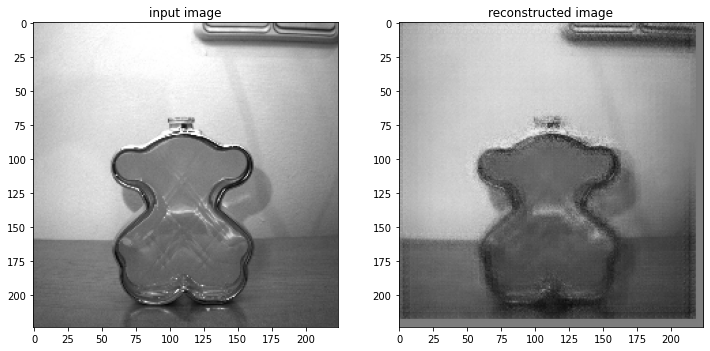

In [33]:
(idx,err) = result_lst[0]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(convert_for_display(image_in_tensor))
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(convert_for_display(Y))
plt.show()

displaying the image that resulted in the lowest reconstruction error:

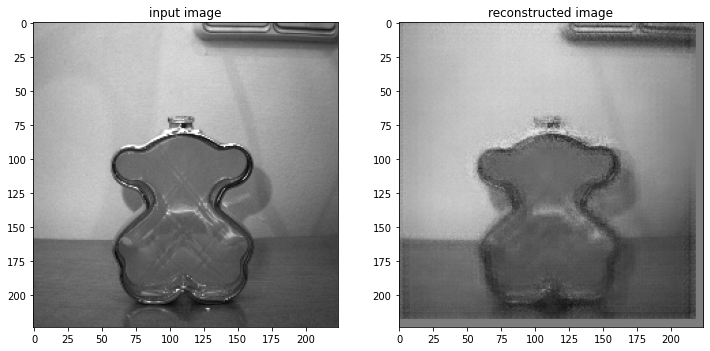

In [34]:
(idx,err) = result_lst[-1]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(convert_for_display(image_in_tensor))
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(convert_for_display(Y))
plt.show()

Plotting and showing info about the reconstruction error values that were obtained

In [35]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

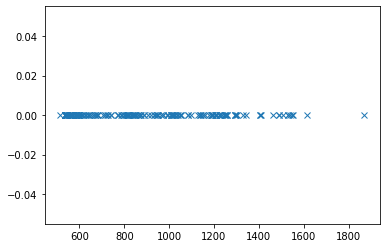

In [36]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [37]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  906.0776616101824
The standard deviation of the errors list is:  303.53192856214076
The min value of the errors list is:  513.120361328125
The max value of the errors list is:  1870.131103515625


## Working with the mean square error

In [38]:
result_lst = []
n_features = len(image_in_tensor[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 2.7829331897553944), (1, 1.476615724109468), (2, 1.797043209984189), (3, 0.8676152910505023), (4, 0.8091629573277065), (5, 0.8690221877325148), (6, 0.9834333147321429), (7, 1.013794671921503), (8, 0.9187216985793341), (9, 0.9096819559733073), (10, 0.8699305398123605), (11, 0.8226214817592076), (12, 1.4787326086135137), (13, 1.3911158243815105), (14, 1.0646949041457403), (15, 1.2113976251511347), (16, 0.8449220203218006), (17, 1.3493748619442893), (18, 1.1030522301083518), (19, 1.9272430056617373), (20, 2.2903104509626115), (21, 2.243107568650019), (22, 1.6163911365327381), (23, 1.2507653009323847), (24, 0.8346056256975446), (25, 0.9685127621605283), (26, 1.527486347016834), (27, 1.5074669974190849), (28, 1.862944103422619), (29, 1.7541353134881883), (30, 0.9354367029099238), (31, 0.928288323538644), (32, 1.499053228469122), (33, 1.5399287995837985), (34, 1.4077884129115514), (35, 1.194937751406715), (36, 1.414684840611049), (37, 1.764189947219122), (38, 1.9803323291596913), (39, 2

In [39]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 2.7829331897553944), (120, 2.404326665969122), (146, 2.3086340767996654), (155, 2.301762172154018), (20, 2.2903104509626115), (176, 2.279600052606492), (168, 2.2773849850609187), (21, 2.243107568650019), (39, 2.2161193121047247), (177, 2.2146909804571244), (175, 2.177070980980283), (137, 2.0959329150971913), (165, 2.0922128586542037), (178, 2.0895176842099143), (163, 2.0010434105282737), (38, 1.9803323291596913), (164, 1.9369281587146578), (167, 1.9292328244163877), (19, 1.9272430056617373), (169, 1.9264722551618303), (161, 1.9260157630557107), (145, 1.8703206380208333), (162, 1.8698229108537947), (28, 1.862944103422619), (144, 1.8613528297061013), (142, 1.8568391345796131), (143, 1.8514195396786643), (141, 1.8387545631045388), (60, 1.825337909516834), (80, 1.825337909516834), (166, 1.8226767040434337), (147, 1.8189937046595983), (140, 1.8004735310872395), (2, 1.797043209984189), (116, 1.7967274983723958), (158, 1.7963652837844122), (160, 1.7905464172363281), (170, 1.7815867832728

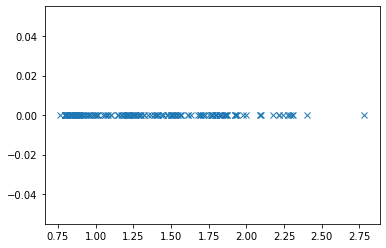

In [40]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [41]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  1.348329853586581
The standard deviation of the errors list is:  0.45168441750318555
The min value of the errors list is:  0.7635719662620908
The max value of the errors list is:  2.7829331897553944


Working with the MSE rather than only SE showed pretty much the same results.

# Checking the MSE of the anomaly images

We first load the anomaly images dataset

In [42]:
data_anomalies = '../../../Images/BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset_anomalies = datasets.ImageFolder(data_anomalies, transform=transform_characteristics)
dataloader_anomalies = torch.utils.data.DataLoader(dataset_anomalies, batch_size=32, shuffle=True)

In [43]:
images, labels = next(iter(dataloader_anomalies))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0])
tensor(0.0028) tensor(1.)


In [44]:
print(len(dataloader_anomalies))

1


Showing one sample of the anomaly images

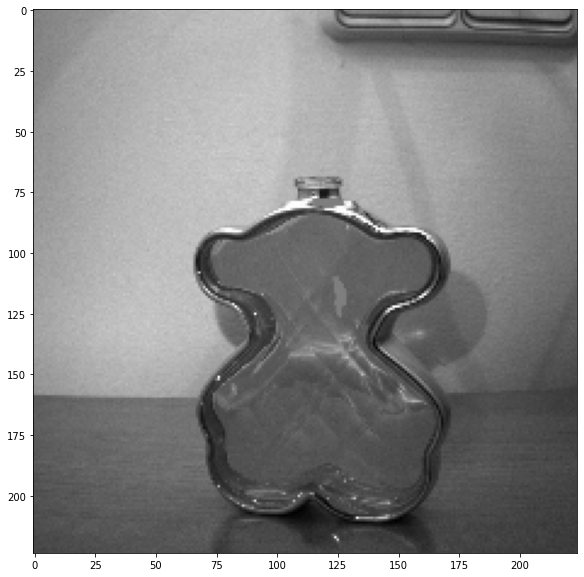

In [45]:
imgs = images.detach().numpy()

single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.figure(figsize=(10, 10))
plt.imshow(new_img_to_show)

In [46]:
print(len(dataset_anomalies))

6


In [47]:
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.9197974432082403), (1, 1.6461535862513952), (2, 1.9432861691429502), (3, 2.7882189069475447), (4, 1.359438759940011), (5, 1.0334960392543249)]


In [48]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(3, 2.7882189069475447), (2, 1.9432861691429502), (1, 1.6461535862513952), (4, 1.359438759940011), (5, 1.0334960392543249), (0, 0.9197974432082403)]


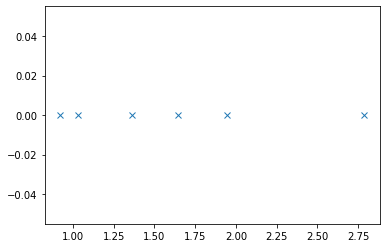

In [49]:
errors_list_anomalies = []
for i in range(len(result_lst)):
    errors_list_anomalies.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [50]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  1.6150651507907445
The standard deviation of the errors list is:  0.6287487484006127
The min value of the errors list is:  0.9197974432082403
The max value of the errors list is:  2.7882189069475447


# Comparing the reconstruction error of anomaly and normal images

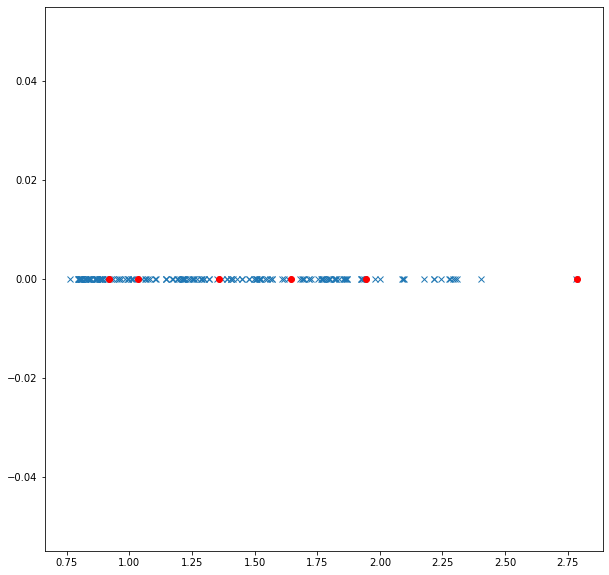

In [51]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

Above see that the reconstruction error between normal and anomaly images are NOT clearly divided in the plot. This could be a problem for the overall detection.

# Coding a function to check if an image contains anomalies

We know that for the non-anomaly images, the mean and std devation is:

In [52]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  1.348329853586581
The standard deviation of the errors list is:  0.45168441750318555
The min value of the errors list is:  0.7635719662620908
The max value of the errors list is:  2.7829331897553944


And for the anomaly image, the std deviation and mean values are:

In [53]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  1.6150651507907445
The standard deviation of the errors list is:  0.6287487484006127
The min value of the errors list is:  0.9197974432082403
The max value of the errors list is:  2.7882189069475447


According to this, we will work with the following:

- The error value is 1.3483. This is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as an anomaly image.
- The error value is 1.3483 +/- 0.451. Then the probability of being detected as an anomaly bottle is 100%.

In [54]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [55]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = 1.3483
    std_dev = 0.4517
    aux_score = abs(value - mean)
    if aux_score > 0.4517:
        aux_score = 0.4517
    # prob_score = ranges_mapper(aux_score, 0, std_dev, 100,0)              # This is considering that the 100% refers to a non-anomaly sample
    prob_score = ranges_mapper(aux_score, 0, std_dev, 0,100)                # This is considering that the 100% refers to an anomaly sample
    return prob_score

In [56]:
print(map_error2prob(1.359438759940011))

2.465964122207441


In [57]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = 1.3483
    std_dev = 0.4517
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = abs(input_list[i] - mean)
        if aux_score > 0.4517:
            aux_score = 0.4517
        # prob_score = ranges_mapper(aux_score, 0, std_dev, 100,0)              # This is considering that the 100% refers to a non-anomaly sample
        prob_score = ranges_mapper(aux_score, 0, std_dev, 0,100)                # This is considering that the 100% refers to an anomaly sample
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

Moreover, we decide whether an image is anomaly or not, based on its reconstruction error.

In [58]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99345408 0.99275514 0.99195325
 0.9790711  0.95923574 0.94269119 0.94189332 0.93423111 0.93309865
 0.9207216  0.89846206 0.83330332 0.81346956 0.81309194 0.77591817
 0.7618167  0.75783258 0.73996695 0.63145215 0.59351591 0.57997664
 0.48835265 0.48567632 0.47295423 0.44370729 0.4242391  0.39669326
 0.38388109 0.38388109 0.37124888 0.35506968 0.35237325 0.34405232
 0.34405232 0.33374635 0.28875937 0.28407289 0.22656228 0.22656228
 0.18355368 0.14696666 0.13169894 0.12542014 0.12542014 0.09478819
 0.088924   0.04692823 

See above that the data points that are in the "middle" of the distribution are the ones who get classified correctly as non-anomaly images, as these show the low probability that was expected. This performance could be due to the poor training time of the model. 

Let's now check the reconstruction error of the anomaly images.

In [59]:
print("Considering the anomaly dataset. The number of images to be cheked is: ", len(errors_list_anomalies))
preds_probs = np.array(map_error2prob_list(errors_list_anomalies))
preds_probs = preds_probs/100
print("The prediction probabilities list for the anomaly images is: ")
print(preds_probs)

Considering the anomaly dataset. The number of images to be cheked is:  6
The prediction probabilities list for the anomaly images is: 
[1.         1.         0.65940577 0.02465964 0.6969315  0.94864414]


See that for the classification of the anomaly images we have a pretty good result. Only one sample is classified as non-anomaly when in reality it was an anomaly image, that is, a false negative. The image that corresponds to the only one false negative sample is:


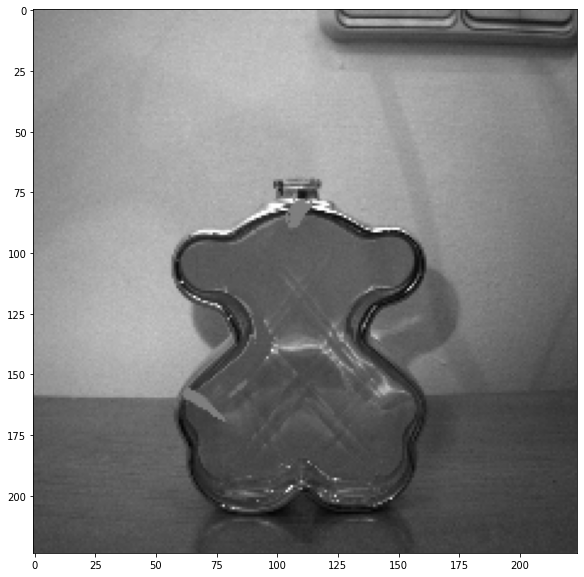

In [60]:
X = dataset_anomalies[4]        # It was seen that the fourth element corresponded to the false negative
image_in_tensor = X[0]

single_img = image_in_tensor.detach().numpy()
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.figure(figsize=(10, 10))
plt.imshow(new_img_to_show)

We can conclude that this model is somehow "good" with the True positives but it is really bad with the False positives.

# Evaluating the performance of the model

So far, it has been used two dataset for doing the above tests: The full non-anomalies dataset and a full anomalies dataset. We will create a third dataset with a mix of these two types of images.

In [62]:
test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
classes = ('non-anomaly','anomaly')

In [63]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred


In [64]:
y_pred = []
y_true = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels

    prediction = computePred(err)
    y_pred.append(prediction) # Save Prediction
    y_true.append(ground_truth) # Save Truth
print(y_true)
print(y_pred)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Above, it can be seen that all the images are predicted to be anomaly images. This is good for the TPR but it is terrible for the FPR. It might be possible to improve the prediction by changing its probability-computation process, instead of being based on the Gaussian distribution, it could be based on a simple threshold. 

Below, it is seen the implementation of the function that computes the probability of the prediction based on a given threshold. We will start first by displaying the value of the reconstruction error of all the values of the test dataset.

In [65]:
result_test_lst = []

X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_test_lst.append( (i,err) )     # idx of data item, err
print(result_test_lst)

[(0, 2.1925484793526784), (1, 2.057481674920945), (2, 1.9236081441243489), (3, 1.9316268194289434), (4, 1.8942662193661643), (5, 1.8573704674130393), (6, 1.9680827912830172), (7, 2.0225243341355097), (8, 2.3342706589471724), (9, 2.1266868228004094), (10, 2.2607716151646207), (11, 2.182919456845238), (12, 2.3086558750697543), (13, 2.115864708310082), (14, 1.957398187546503), (15, 2.2552344912574407), (16, 1.6798097519647508), (17, 1.618731907435826), (18, 1.9160020010811942), (19, 2.433851332891555), (20, 2.419931865873791), (21, 2.503220694405692), (22, 2.6136478242420016), (23, 2.5926177615211126), (24, 2.2990626380557107), (25, 2.39716793241955), (26, 2.371148245675223), (27, 2.3177386692592075), (28, 2.3020555405389693), (29, 2.4502410888671875)]


Inspectioning the min and max values of the anomaly and non-anomaly results we have:

In [72]:
rec_error_non_anomaly_lst = []
aux = result_test_lst[0:25]
for i in range (len(aux)):
    rec_error_non_anomaly_lst.append(aux[i][1])

average_recon_error = np.mean(np.array(rec_error_non_anomaly_lst))  
stdev_recon_error = np.std(np.array(rec_error_non_anomaly_lst)) 

print("The min value of reconstruction error of the non-anomaly list is: ", min(rec_error_non_anomaly_lst))
print("The max value of reconstruction error of the non-anomaly list is: ", max(rec_error_non_anomaly_lst))

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)

The min value of reconstruction error of the non-anomaly list is:  1.618731907435826
The max value of reconstruction error of the non-anomaly list is:  2.6136478242420016
The average of the errors list is:  2.1386474609375
The standard deviation of the errors list is:  0.2606302027143829


In [73]:
rec_error_anomaly_lst = []
aux = result_test_lst[25:29]
for i in range (len(aux)):
    rec_error_anomaly_lst.append(aux[i][1])

average_recon_error = np.mean(np.array(rec_error_anomaly_lst))  
stdev_recon_error = np.std(np.array(rec_error_anomaly_lst)) 

print("The min value of reconstruction error of the non-anomaly list is: ", min(rec_error_anomaly_lst))
print("The max value of reconstruction error of the non-anomaly list is: ", max(rec_error_anomaly_lst))

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)

The min value of reconstruction error of the non-anomaly list is:  2.3020555405389693
The max value of reconstruction error of the non-anomaly list is:  2.39716793241955
The average of the errors list is:  2.3470275969732377
The standard deviation of the errors list is:  0.03865289794775427


From above we can conclude that everything above 2.30 in reconstruction error will be considered as an anomaly image.

In [74]:
def map_error2prob_list_v2(input_list):
    threshold = 2.30
    std_dev = 0.039
    prob_score_list = []
    prob_score = 50
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        
        if aux_score>=0:
            additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
            prob_score_tot = prob_score+additional
        else:
            additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
            prob_score_tot = prob_score-additional
        if prob_score_tot > 100:
            prob_score_tot = 100
        if prob_score_tot < 0:
            prob_score_tot = 0
        prob_score_list.append(prob_score_tot)
    return prob_score_list

In [80]:
def map_error2prob_list_v2(value):
    threshold = 2.30
    std_dev = 0.039
    prob_score = 50
    aux_score = value - threshold
        
    if aux_score>=0:
        additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
        prob_score_tot = prob_score+additional
    else:
        additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        prob_score_tot = prob_score-additional
    if prob_score_tot > 100:
        prob_score_tot = 100
    if prob_score_tot < 0:
        prob_score_tot = 0    
    return prob_score_tot

In [ ]:
def computePred_v2(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [61]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [ ]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
      